In [1]:
from dask.distributed import Client
client = Client() 

In [2]:
client

Client Scheduler: tcp://127.0.0.1:39312,Cluster Workers: 8 Cores: 8 Memory: 8.46 GB


In [1]:
from dask import dataframe
import sys
import spacy                           # See "Installing spaCy"
import pandas as pd
import json
from nltk.corpus import stopwords
from gensim import corpora,models,similarities
import itertools
nlp = spacy.load('en')  

C:\Python35\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [5]:
# from nltk.tokenize import RegexpTokenizer
# tokenizer = RegexpTokenizer(r'\w+')
# movies['storyLineTok'] = movies['storyLine'].apply(lambda x: ' '.join(tokenizer.tokenize(str(x))))
def remove_stopwords(text):
    stop_words = stopwords.words('English')
    return [w for w in text.split(' ') if w not in stop_words]

def remove_named_entities(text):
    doc = nlp(text)
    
    names = list()
    for ent in doc.ents:
        names.extend(ent.text.split(' '))
    return [w for w in text.split(' ') if w not in names]

def preprocess(text):
    try:
        lemmas = [token.lemma_ for token in nlp(text.replace('\n','')) if not (token.is_stop or token.is_title or token.is_punct or token.is_digit)]
        return lemmas
    except :
        print(text,sys.exc_info()[0])
        return [' ']

In [6]:
# .loc[0:500]
movies = pd.read_csv('data/ml-latest-small/movies.csv',dtype=str)
synopses = pd.read_json('data/synopsis_full.json' , dtype=str)
movies['storyLine'] = synopses['storyLine']

In [11]:
movies_ds = dataframe.from_pandas(movies, npartitions=8)
movies_ds = client.persist(movies_ds)


In [12]:
movies_ds['storyLineProcessedDS'] = movies['storyLine'].apply(lambda x : (preprocess(x)))

In [13]:
# movies['storyLineProcessed'] = movies['storyLine'].apply(lambda x : ' '.join(preprocess(x)))
movies['storyLineProcessed'] = movies['storyLine'].apply(lambda x : (preprocess(x)))

In [122]:
movies_ds.head()

,movieId,title,genres,imdbId,tmdbId,storyLine,storyLineProcessedDS
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862,\nA little boy named Andy loves to be in his r...,"[little, boy, name, love, room, play, toy, esp..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844,\nAfter being trapped in a jungle board game f...,"[trap, jungle, board, game, year, win, release..."
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602,\nThings don't seem to change much in Wabasha ...,"[not, change, fight, year, drink, smoke, chase..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357,\nThis story based on the best selling novel b...,"[story, base, good, selling, novel, mcmillan, ..."
4,5,Father of the Bride Part II (1995),Comedy,113041,11862,"\nIn this sequel to ""Father of the Bride"", Geo...","[sequel, accept, reality, daughter, 's, ascens..."


In [131]:
with open('data/movies_with_storyline.pickle','wb') as file:
    pickle.dump(movies,file)

In [124]:
documents = list(movies['storyLineProcessed'])
# texts = [[w for w in document.split(' ')] for document in documents]

In [132]:
dictionary = corpora.Dictionary(documents)

In [133]:
corpus = [dictionary.doc2bow(document) for document in documents]

In [147]:
cnt = 0
for key,val in dictionary.iteritems():
    cnt+=1

In [148]:
cnt

17799

In [137]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [149]:
numpy_matrix = gensim.matutils.corpus2dense(corpus, num_terms=17799)
s = np.linalg.svd(numpy_matrix, full_matrices=False, compute_uv=False)

In [173]:
with open('movie_svd.pickle','wb') as file:
    pickle.dump(s, file)

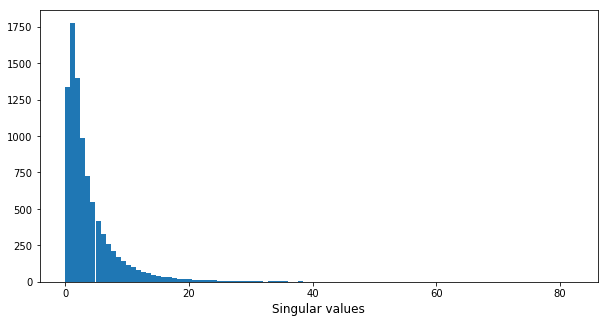

In [180]:
plt.figure(figsize=(10,5))
plt.hist(s[:], bins=100)
plt.xlabel('Singular values', fontsize=12)
plt.show()

In [206]:
np.count_nonzero(s>30)

55

In [208]:
s[0:12]

array([ 170.83207703,   81.98419952,   64.3264389 ,   60.58366013,
         54.90364075,   54.15921783,   51.39440155,   50.52922058,
         47.34321213,   47.08308029,   45.71079254,   44.40297318], dtype=float32)

In [201]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=20)
index = similarities.MatrixSimilarity(lsi[corpus_tfidf]) # transform corpus to LSI space and index it


In [202]:
index

ValueError: x and y must have same first dimension, but have shapes (21,) and (1,)

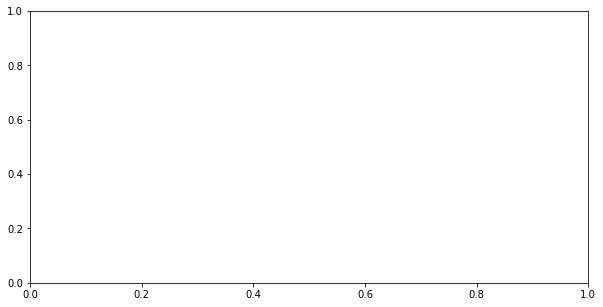

In [176]:
plt.figure(figsize=(10,5))
plt.plot(range(0,101,5), 60, '*-')
plt.xlabel('Threshold of singular values', fontsize=12)
plt.ylabel('Number of topics', fontsize=12)

In [167]:
np.count_nonzero(s<10)

8324

In [168]:
len(s)

9125

In [198]:
genres = []
for gset in list(movies['genres']):
    for g in gset.split('|'):
        genres.append(g)


In [199]:
set(genres)

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}